Initialization. As I use functions from the tranX model to compute bleu, it is necessary to add path to the folder to the system path (maybe better just add them here?)

In [1]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random
from collections import Counter, defaultdict
from operator import itemgetter
from scipy.stats import pearsonr as pear
from scipy.stats import spearmanr as spear
from scipy.stats import kendalltau as kend
import scipy.stats as stats
import os
import sys
sys.path.append(os.getcwd()+'/datasets/tranX/datasets/conala/')
#sys.path.append(os.getcwd()+'/codebleu/')
#sys.path.append(os.getcwd()+'/codebleu/tree-sitter-python')
sys.path.append(os.getcwd()+'/typilus/typilus/src/data_preparation/scripts')
import graph_generator.graphgenerator as gg
import graph_generator.graphgenutils as gu

In [2]:
def myround(a, b): #for averaging Misha and Egor grades
    if random.randint(1,2) == 1:
        return int(round((a+b-0.001)/2,0))
    else:
        return int(round((a+b+0.001)/2,0))
def upround(a, b):
    return int(round((a+b+0.001)/2,0))
def myroundlist(a): #for averaging multiple grades for same snippet
    if random.randint(1,2) == 1:
        return int(round((sum(a)-0.001)/len(a),0))
    else:
        return int(round((sum(a)+0.001)/len(a),0))

# Data preprocessing

In [3]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from conala_eval import tokenize_for_bleu_eval as tknz
from bleu_score import compute_bleu
import myrouge as rouge
from ruby.similarity import ruby as ruby
from codebleu.codebleu import codebleu as cbl
import mymeteor as mym
fields = ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']
all_fields = ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank', 'snippet']
all_names = ['snippet', 'baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']
metrics = ['bleu', 'rougel', 'meteor', 'ruby', 'codebleu']
data_hearth = json.load(open('hs.json'))
data_django = json.load(open('django.json'))
from graph_generator.type_lattice_generator import TypeLatticeGenerator
lattice = TypeLatticeGenerator('typingRules.json')

The original dataset is dirty: there are questions with literally same intent (and same question_id) that appear several times in the conala-test with different reference snippets. This corresponds to the multiple reference solutions that should be considered for the metrics computation. Beforehand we didn't pay attention, which lead to the wrong results for the metrics accuracy (the results were artificially lowered, as the model could only guess one possible form of snippet from one intent, see clean_dataset[5] for an example). Therefore, we need to glue together cases with the same snippets; the original dataset is called 'dirty_dataset' and the one with pruned examples is called 'clean_dataset'.

In [4]:
#dirty_dataset = json.load(open('./metrics-evaluation/to-grade/all-singles.json'))
dirty_dataset = json.load(open('./to-grade/all-singles.json'))
for d in dirty_dataset:
    for k, v in d.items():
        d[k] = [v]

In [5]:
to_remove = []
for i, d1 in enumerate(dirty_dataset):
    for j, d2 in enumerate(dirty_dataset):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in all_names:
                d1[n].append(d2[n][0])
clean_dataset = [dirty_dataset[j] for j in range(len(dirty_dataset)) if j not in to_remove]

## BLEU

This (and the next following sections) correspond to the metric computation. The only thing to notice is that BLEU results depend on the smoothing function (smooth = SmoothingFunction().method#; # is the number from 1 to 5). In the end we get updated clean_dataset with all grades for all metrics

In [6]:
for i, d in enumerate(clean_dataset):
    for n in fields:
        hyp = [tknz(hp.strip()) for hp in d[n]]
        snp = [tknz(sn.strip()) for sn in d['snippet']]
        d['grade-bleu-'+n] = round(compute_bleu([snp], hyp, smooth = SmoothingFunction().method3)[0],4)

## ROUGE-L

In [7]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2)
for nam in fields:
    keyn = 'grade-rougel-'+nam
    for d in clean_dataset:
        hypt = d[nam]
        refr = d['snippet']
        if hypt[0] != '':
            scores = evaluator.get_scores(hypt, refr)
            d[keyn] = round(scores['rouge-l']['f'], 4)
        else:
            d[keyn] = 0.0

## METEOR

In [8]:
for nam in fields:
    keyn = 'grade-meteor-'+nam
    for d in clean_dataset:
        hypt = d[nam][0]
        refr = d['snippet']
        if hypt != '':
            d[keyn] = round(mym.meteor_score(refr, hypt), 4)
        else:
            d[keyn] = 0.0

## RUBY

In [9]:
for entry in clean_dataset:
    for field in fields:
        ruby_grade = 0.0
        sample = entry[field][0].replace('`', '"')
        for snp in entry['snippet']:
            ruby_grade = max(ruby_grade, ruby(sample, snp)[0])
        entry['grade-ruby-'+field] = ruby_grade

## CodeBLEU

In [10]:
for entry in clean_dataset:
    for field in fields:
        grade = 0.0
        for snp in entry['snippet']:
            try:
                grade = max(grade, cbl(snp, entry[field][0]))
            except:
                print(field, entry[field])
        entry['grade-codebleu-'+field] = grade

In [11]:
cbl(snp, entry[field][0])

0.49621212121212116

In [12]:
clean_dataset

[{'intent': ['send a signal `signal.SIGUSR1` to the current process'],
  'snippet': ['os.kill(os.getpid(), signal.SIGUSR1)'],
  'baseline': ["os.system('<unk>.png',s = 300)"],
  'tranx-annot': ['sys.signal(`signal.SIGUSR1`)'],
  'best-tranx': ['os.system(`signal.SIGUSR1`)'],
  'best-tranx-rerank': ['os.system(`< unk > < unk > < unk >`)'],
  'grade-bleu-baseline': 0.1251,
  'grade-bleu-tranx-annot': 0.1809,
  'grade-bleu-best-tranx': 0.201,
  'grade-bleu-best-tranx-rerank': 0.115,
  'grade-rougel-baseline': 0.4,
  'grade-rougel-tranx-annot': 0.5,
  'grade-rougel-best-tranx': 0.5833,
  'grade-rougel-best-tranx-rerank': 0.2667,
  'grade-meteor-baseline': 0.3003,
  'grade-meteor-tranx-annot': 0.3758,
  'grade-meteor-best-tranx': 0.4667,
  'grade-meteor-best-tranx-rerank': 0.1408,
  'grade-ruby-baseline': 0.5539568345323741,
  'grade-ruby-tranx-annot': 0.4380165289256198,
  'grade-ruby-best-tranx': 0.5289256198347108,
  'grade-ruby-best-tranx-rerank': 0.5289256198347108,
  'grade-codebleu-b

## Statistical tests for computer metrics

Here we split all grades for all metrics into a dictionary of dictionaries that has metric and model as keys and list of all grades as a value. We then use it to run Wilcoxon signed-rank test

In [13]:
from collections import defaultdict
split_grades = defaultdict(dict)
for metric in metrics:
    for field in fields:
        split_grades[metric][field] = []
for entry in clean_dataset:
    for metric in metrics:
        for field in fields:
            split_grades[metric][field].append(entry['grade-'+metric+'-'+field])

In [15]:
import scipy.stats as stats
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'rougel', 'meteor', 'ruby', 'codebleu']:
    for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(split_grades[metric][field1], split_grades[metric][field2], alternative='less')[1],5))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric,Model A,Model B,Wilcoxon
bleu,baseline,tranx-annot,0.0
bleu,baseline,best-tranx,0.0
bleu,baseline,best-tranx-rerank,0.0
bleu,tranx-annot,best-tranx,0.03264
bleu,tranx-annot,best-tranx-rerank,0.00014
bleu,best-tranx,best-tranx-rerank,0.00031
rougel,baseline,tranx-annot,0.0
rougel,baseline,best-tranx,0.0
rougel,baseline,best-tranx-rerank,0.0
rougel,tranx-annot,best-tranx,0.01123


In [23]:
for metric in metrics:
    for field in fields:
        print(metric + " " + field + " " +str(sum(split_grades[metric][field])/len(split_grades[metric][field])))

bleu baseline 0.15263411016949155
bleu tranx-annot 0.26496906779660995
bleu best-tranx 0.28414745762711857
bleu best-tranx-rerank 0.30062097457627096
rougel baseline 0.40177796610169525
rougel tranx-annot 0.5400707627118647
rougel best-tranx 0.5578790254237296
rougel best-tranx-rerank 0.5734192796610172
meteor baseline 0.28547669491525407
meteor tranx-annot 0.441459533898305
meteor best-tranx 0.4660938559322034
meteor best-tranx-rerank 0.48397754237288154
ruby baseline 0.42141081864588353
ruby tranx-annot 0.4616417291801655
ruby best-tranx 0.49256695056971717
ruby best-tranx-rerank 0.5188810859106059
codebleu baseline 0.30968123313486895
codebleu tranx-annot 0.3301419065702194
codebleu best-tranx 0.3406710289332378
codebleu best-tranx-rerank 0.34323728244426865


## Statistics for humans

Here we clean up the human grades dataset and compute Wilcoxon test (similarly to what we did with the metric scores). As there are 8 points missing in Egor grades, I have submitted my scores for them. This is dirty and I will fix this later, but this can hardly affect the results (8 points correspond to 0.3% sample points)

In [24]:
data_misha = json.load(open('to-grade/all-singles-done.json'))
data_egor = json.load(open('to-grade/all-singles.egor.json'))

In [25]:
grade_names = ['grade-baseline', 'grade-tranx-annot', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-snippet']
for entry in data_egor:
    for n in grade_names:
        if entry.get(n) is not None:
            entry[n] = [entry[n]]
        else:
            entry[n] = []

In [26]:
to_remove = []
for i, d1 in enumerate(data_egor):
    for j, d2 in enumerate(data_egor):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in grade_names:
                if len(d2[n]) > 0:
                    d1[n].append(d2[n][0])
clean_egor = [data_egor[j] for j in range(len(data_egor)) if j not in to_remove]

In [27]:
for entry in data_misha:
    for n in grade_names:
        if entry.get(n) is not None:
            entry[n] = [entry[n]]
        else:
            entry[n] = []

In [28]:
to_remove = []
for i, d1 in enumerate(data_misha):
    for j, d2 in enumerate(data_misha):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in grade_names:
                if len(d2[n]) > 0:
                    d1[n].append(d2[n][0])
clean_misha = [data_misha[j] for j in range(len(data_misha)) if j not in to_remove]

In [29]:
grades_misha = {'baseline': [], 'tranx-annot': [], 'best-tranx': [], 'best-tranx-rerank': [], 'snippet': []}
for entry in clean_misha:
    for field in all_fields:
        grades_misha[field].append(myroundlist(entry['grade-'+field]))

In [30]:
grades_egor = {'baseline': [], 'tranx-annot': [], 'best-tranx': [], 'best-tranx-rerank': [], 'snippet': []}
for i, entry in enumerate(clean_egor):
    for field in all_fields:
        try:
            tmp = myroundlist(entry['grade-'+field])
        except: 
            tmp = myroundlist(clean_misha[i]['grade-'+field])
        grades_egor[field].append(tmp)

In [31]:
tmp = [['Grader', 'Model A', 'Model B', 'Wilcoxon']]
for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
    for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        if i < j:
            tmp.append(['Misha', field1, field2, str(round(stats.wilcoxon(grades_misha[field1], grades_misha[field2], alternative='less')[1],5))])
for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
    for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        if i < j:
            tmp.append(['Egor', field1, field2, str(round(stats.wilcoxon(grades_egor[field1], grades_egor[field2], alternative='less')[1],5))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Grader,Model A,Model B,Wilcoxon
Misha,baseline,tranx-annot,0.0
Misha,baseline,best-tranx,0.0
Misha,baseline,best-tranx-rerank,0.0
Misha,tranx-annot,best-tranx,3e-05
Misha,tranx-annot,best-tranx-rerank,0.0
Misha,best-tranx,best-tranx-rerank,0.00228
Egor,baseline,tranx-annot,0.0
Egor,baseline,best-tranx,0.0
Egor,baseline,best-tranx-rerank,0.0
Egor,tranx-annot,best-tranx,0.0


## Combined statistics

In [32]:
grades = eval(open('conala-integrated.txt').read())

In [33]:
all_grades_names = ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank', 'snippet']
for key, value in grades.items():
    num = int(key)
    grade_name = 'grade-average-'+all_grades_names[int(num / len(clean_dataset))]
    clean_dataset[num % len(clean_dataset)][grade_name] = int(max(value, key=value.get))

In [34]:
grades_diff = defaultdict()
for metric in metrics:
    grades_diff[metric] = [dict() for _ in range(len(clean_dataset))]
grades_diff['average'] = [dict() for _ in range(len(clean_dataset))]
for metric in metrics:
    for i, item in enumerate(clean_dataset):
        for grade in ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']:
            grades_diff[metric][i][grade] = item['grade-average-'+grade]/4.0 - item['grade-'+metric+'-'+grade]
        grades_diff[metric][i]['num'] = i   
for i, item in enumerate(clean_dataset):
    for grade in ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']:
        grades_diff['average'][i][grade] = item['grade-average-'+grade]/4.0
    grades_diff['average'][i]['num'] = i   

In [35]:
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby', 'codebleu', 'average']

## Inflection points

In [165]:
def find_inflection(grades, left, right, check_metric, list_fields):
    if (right - left) < 2:
        return right
    t23 = [clean_dataset[it['num']] for it in grades[0:upround(left, right)]]
    split_grades23 = defaultdict(dict)
    for metric in [check_metric, 'average']:
        for field in list_fields:
            split_grades23[metric][field] = []
    for entry in t23:
        for metric in [check_metric, 'average']:
            for field in list_fields:
                split_grades23[metric][field].append(entry['grade-'+metric+'-'+field])
    if (round(stats.wilcoxon(split_grades23[metric][list_fields[1]], split_grades23[metric][list_fields[0]], alternative='greater')[1],3) < 0.95):
        return find_inflection(grades, left, upround(left, right), check_metric, list_fields)
    else:
        return find_inflection(grades, upround(left, right), right, check_metric, list_fields)

In [180]:
gd23 = {metric: sorted(grades_diff[metric], key = lambda k: k['best-tranx'] - k['baseline']) for metric in all_metrics}
print(find_inflection(gd23['bleu'], 5, len(clean_dataset), 'bleu', ['baseline', 'best-tranx']))

67


In [172]:
t23 = [clean_dataset[it['num']] for it in gd23['bleu'][0:5]]
split_grades23 = defaultdict(dict)
for metric in ['bleu', 'average']:
    for field in ['baseline', 'best-tranx']:
        split_grades23[metric][field] = []
for entry in t23:
    for metric in ['bleu', 'average']:
        for field in ['baseline', 'best-tranx']:
            split_grades23[metric][field].append(entry['grade-'+metric+'-'+field])
stats.wilcoxon(split_grades23[metric]['best-tranx'], split_grades23[metric]['baseline'], alternative='greater')

WilcoxonResult(statistic=1.0, pvalue=0.8574752962986936)

In [177]:
tmp = [['Metric', 'Model A', 'Model B', 'Inflection point 1', 'Inflection point 2']]
for i1, grade1 in enumerate(fields):
    for i2, grade2 in enumerate(fields):
        if (i2 > i1):
            gd23 = dict()
            for metric in all_metrics:
                gd23 = sorted(grades_diff[metric], key = lambda k: k[grade2] - k[grade1])
                tmp.append([metric, grade2, grade1, find_inflection(gd23, 10, len(clean_dataset), metric, [grade1, grade2]), find_inflection(gd23, 20, len(clean_dataset), metric, [grade1, grade2])])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))        

Metric,Model A,Model B,Inflection point 1,Inflection point 2
bleu,tranx-annot,baseline,98,98
rougel,tranx-annot,baseline,151,151
meteor,tranx-annot,baseline,108,108
ruby,tranx-annot,baseline,55,55
average,tranx-annot,baseline,266,266
bleu,best-tranx,baseline,67,67
rougel,best-tranx,baseline,66,66
meteor,best-tranx,baseline,46,50
ruby,best-tranx,baseline,25,25
average,best-tranx,baseline,202,202


In [137]:
from collections import defaultdict
split_grades23 = defaultdict(dict)
for metric in ['bleu', 'average']:
    for field in fields:
        split_grades23[metric][field] = []
for entry in t23:
    for metric in ['bleu', 'average']:
        for field in fields:
            split_grades23[metric][field].append(entry['grade-'+metric+'-'+field])

In [138]:
import scipy.stats as stats
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'average']:
    for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(split_grades23[metric][field1], split_grades23[metric][field2], alternative='less')[1],5))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric,Model A,Model B,Wilcoxon
bleu,baseline,tranx-annot,1e-05
bleu,baseline,best-tranx,0.0
bleu,baseline,best-tranx-rerank,0.0
bleu,tranx-annot,best-tranx,0.06557
bleu,tranx-annot,best-tranx-rerank,0.00272
bleu,best-tranx,best-tranx-rerank,0.03535
average,baseline,tranx-annot,0.2959
average,baseline,best-tranx,0.06322
average,baseline,best-tranx-rerank,0.96184
average,tranx-annot,best-tranx,0.18739


## Correlations

Here we compute Spearman r and Kendall tau for all pairs of metrics and graders. As we want to compare across all datasets, we concatenate the lists for each dataset together.

In [36]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
all_grades = {'bleu': [], 'rougel': [], 'meteor': [], 'ruby': [], 'codebleu': []}
for metric in metrics:
    for field in fields:
        all_grades[metric] = all_grades[metric] + split_grades[metric][field]
gradesm = []
gradese = []
for field in fields:
    gradesm = gradesm + grades_misha[field]
    gradese = gradese + grades_egor[field]

for i, metric1 in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i < j:
            grades1 = []
            grades2 = []
            for field in fields:
                grades1 = grades1 + split_grades[metric1][field]
                grades2 = grades2 + split_grades[metric2][field]
            tmp.append([metric1, metric2, str(round(stats.spearmanr(all_grades[metric1], all_grades[metric2])[0],3)), str(round(stats.kendalltau(all_grades[metric1], all_grades[metric2])[0],3))])
    tmp.append([metric1, 'Misha', str(round(stats.spearmanr(all_grades[metric1], gradesm)[0],3)), str(round(stats.kendalltau(all_grades[metric1], gradesm)[0],3))])
    tmp.append([metric1, 'Egor', str(round(stats.spearmanr(all_grades[metric1], gradese)[0],3)), str(round(stats.kendalltau(all_grades[metric1], gradese)[0],3))])
#gradesm = gradesm + grades_misha['snippet']
#gradese = gradese + grades_egor['snippet']
tmp.append(['Egor', 'Misha', str(round(stats.spearmanr(gradese, gradesm)[0],3)), str(round(stats.kendalltau(gradese, gradesm)[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))
for metric in metrics:
    all_grades[metric] = all_grades[metric] + [1.0 for _ in range(len(clean_dataset))] #for the reference snippet
gradesm = gradesm + grades_misha['snippet']
gradese = gradese + grades_egor['snippet']

Metric 1,Metric 2,Spearman,Kendall tau
bleu,rougel,0.858,0.677
bleu,meteor,0.868,0.685
bleu,ruby,0.561,0.406
bleu,codebleu,0.481,0.337
bleu,Misha,0.482,0.377
bleu,Egor,0.47,0.372
rougel,meteor,0.88,0.71
rougel,ruby,0.589,0.432
rougel,codebleu,0.459,0.323
rougel,Misha,0.511,0.403


In [147]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
all_grades = {'bleu': [], 'rougel': [], 'meteor': [], 'ruby': [], 'average': []}
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby', 'average']
for metric in all_metrics:
    for field in fields:
        for i in range(len(clean_dataset)):
            tt = 'grade-'+metric+'-'+field
            all_grades[metric].append(clean_dataset[i][tt])

for i, metric1 in enumerate(all_metrics):
    for j, metric2 in enumerate(all_metrics):
        if i < j:
            tmp.append([metric1, metric2, str(round(stats.spearmanr(all_grades[metric1], all_grades[metric2])[0],3)), str(round(stats.kendalltau(all_grades[metric1], all_grades[metric2])[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))


Metric 1,Metric 2,Spearman,Kendall tau
bleu,rougel,0.747,0.615
bleu,meteor,0.74,0.599
bleu,ruby,0.501,0.386
bleu,average,0.503,0.428
rougel,meteor,0.88,0.71
rougel,ruby,0.649,0.476
rougel,average,0.542,0.427
meteor,ruby,0.58,0.415
meteor,average,0.538,0.422
ruby,average,0.39,0.3


In [37]:
grades_average = {'baseline': [], 'tranx-annot': [], 'best-tranx': [], 'best-tranx-rerank': []}
for item in clean_dataset:
    for field in fields:
        grades_average[field].append(item['grade-average-'+field])

In [38]:
tmp = [['Grader', 'Model A', 'Model B', 'Wilcoxon']]
for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
    for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        if i < j:
            f1 = 'grade-average-'+field1
            f2 = 'grade-average-'+field2
            tmp.append(['Human average', field1, field2, str(round(stats.wilcoxon(grades_average[field1], grades_average[field2], alternative='less')[1],17))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Grader,Model A,Model B,Wilcoxon
Human average,baseline,tranx-annot,0.0
Human average,baseline,best-tranx,0.0
Human average,baseline,best-tranx-rerank,0.0
Human average,tranx-annot,best-tranx,4.503180442e-08
Human average,tranx-annot,best-tranx-rerank,8.959076e-11
Human average,best-tranx,best-tranx-rerank,0.01229760381277676


## Logistic regression

Here we train logistic regression to infer the human grades from the computer metrics

In [152]:
#del bleulog, outbleu, metlog, outmet, roulog, outrou, rubylog, outruby, mishalog, outmisha
seedbleu = [0.001*i for i in range(1001)]
#logus = [myround(gradese[i], gradesm[i]) for i in range(len(gradese))]
from sklearn.linear_model import LogisticRegression
import numpy as np
bleulog = LogisticRegression()
bleulog.fit(np.array(all_grades['bleu']).reshape(-1, 1), np.array(all_grades['average']).reshape(-1, 1))
outbleu = bleulog.predict_proba(np.array(seedbleu).reshape(-1,1))
metlog = LogisticRegression()
metlog.fit(np.array(all_grades['meteor']).reshape(-1, 1), np.array(all_grades['average']).reshape(-1, 1))
outmet = metlog.predict_proba(np.array(seedbleu).reshape(-1,1))
roulog = LogisticRegression()
roulog.fit(np.array(all_grades['rougel']).reshape(-1, 1), np.array(all_grades['average']).reshape(-1, 1))
outrou = roulog.predict_proba(np.array(seedbleu).reshape(-1,1))
rubylog = LogisticRegression()
rubylog.fit(np.array(all_grades['ruby']).reshape(-1, 1), np.array(all_grades['average']).reshape(-1, 1))
outruby = rubylog.predict_proba(np.array(seedbleu).reshape(-1,1))
#mishalog = LogisticRegression()
#mishalog.fit(np.array(gradesm).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
#outmisha = mishalog.predict_proba(np.array([0,1,2,3,4]).reshape(-1,1))

/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConvers

The following two cells give a distribution of probability for the sum of inferred human grades for every snippet in a dataset

In [153]:
def contract_prob(biglist, smlist, cut):
    outlist = [0]*(len(biglist))
    for i in range(cut):
        for j in range(len(smlist)):
            outlist[i+j] += biglist[i]*smlist[j]
    return outlist

In [154]:
names = ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']
metrics = ['bleu', 'rougel', 'meteor', 'ruby']
m2 = {'bleu': outbleu, 'rougel': outrou, 'meteor': outmet, 'ruby': outruby}
probdict = defaultdict(dict)
#problist = [0]*2001
#problist[0] = 1
for metric in metrics:
    for nam in names:
        probdict[metric][nam] = [0 for i in range(4*len(clean_dataset)+1)]
        probdict[metric][nam][0] = 1
        cut = 1
        for j in split_grades[metric][nam]:
            probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(j,3))], cut)
            cut += 4
#for nam in names:
#    probdict['misha'][nam] = [0 for i in range(4*len(clean_dataset)+1)]
#    probdict['misha'][nam][0] = 1
#    cut = 1
#    for j in grades_misha[nam]:
#        probdict['misha'][nam] = contract_prob(probdict[metric][nam], outmisha.tolist()[j], cut)
#        cut += 4

In [157]:
tmp = []
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby']
tmp.append(['Metric', 'Model 1', 'Model 2', 'P(2 > 1)'])
for metric in all_metrics:
    for j, nam1 in enumerate(names):
        for k, nam2 in enumerate(names):
            if j < k:
                comp_prob = 0
                for i in range(len(probdict[metric][nam1])-1):
                    comp_prob += probdict[metric][nam1][i]*sum(probdict[metric][nam2][i+1:])
                tmp.append([metric, nam1, nam2, str(round(1.0-comp_prob, 5))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))                          

Metric,Model 1,Model 2,P(2 > 1)
bleu,baseline,tranx-annot,4e-05
bleu,baseline,best-tranx,0.0
bleu,baseline,best-tranx-rerank,0.0
bleu,tranx-annot,best-tranx,0.18151
bleu,tranx-annot,best-tranx-rerank,0.0803
bleu,best-tranx,best-tranx-rerank,0.31538
rougel,baseline,tranx-annot,0.0
rougel,baseline,best-tranx,0.0
rougel,baseline,best-tranx-rerank,0.0
rougel,tranx-annot,best-tranx,0.27468


# Worst-case scenario for BLEU etc.

Here we consider the case when only one of the references out of few is available and check whether this can disrupt computer metrics

In [199]:
#dirty_dataset = json.load(open('./metrics-evaluation/to-grade/all-singles.json'))
dirty_dataset = json.load(open('./to-grade/all-singles.json'))
for d in dirty_dataset:
    for k, v in d.items():
        d[k] = [v]

In [200]:
to_remove = []
for i, d1 in enumerate(dirty_dataset):
    for j, d2 in enumerate(dirty_dataset):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in all_names:
                d1[n].append(d2[n][0])
clean_dataset = [dirty_dataset[j] for j in range(len(dirty_dataset)) if j not in to_remove]

## BLEU

This (and the next following sections) correspond to the metric computation. The only thing to notice is that BLEU results depend on the smoothing function (smooth = SmoothingFunction().method#; # is the number from 1 to 5). In the end we get updated clean_dataset with all grades for all metrics

In [261]:
def find_opt(d): #maximizes p-value
    snp = [tknz(sn.strip()) for sn in d['snippet']]
    ta = [tknz(hp.strip()) for hp in d['tranx-annot']]
    bt = [tknz(hp.strip()) for hp in d['best-tranx']]
    btr = [tknz(hp.strip()) for hp in d['best-tranx-rerank']]
    opt_ta = -1
    opt_bt = -1
    for i, sn in enumerate(snp):
        ta_score = compute_bleu([[sn]], ta)[0]
        bt_score = compute_bleu([[sn]], bt)[0]
        btr_score = compute_bleu([[sn]], btr)[0]
#        print(ta_score-bt_score)
        if opt_ta < (ta_score - bt_score): 
            i_ta = i
            opt_ta = (ta_score - bt_score)
        if opt_bt < (bt_score - btr_score):
            i_bt = i
            opt_bt = (bt_score - btr_score)
    return i_ta, i_bt

In [272]:
def find_min(d): #maximizes p-value
    snp = [tknz(sn.strip()) for sn in d['snippet']]
    ta = [tknz(hp.strip()) for hp in d['tranx-annot']]
    bt = [tknz(hp.strip()) for hp in d['best-tranx']]
    btr = [tknz(hp.strip()) for hp in d['best-tranx-rerank']]
    opt_ta = -1
    opt_bt = -1
    for i, sn in enumerate(snp):
        ta_score = compute_bleu([[sn]], ta)[0]
        bt_score = compute_bleu([[sn]], bt)[0]
        btr_score = compute_bleu([[sn]], btr)[0]
#        print(ta_score-bt_score)
        if opt_ta < (bt_score - ta_score): 
            i_ta = i
            opt_ta = (bt_score - ta_score)
        if opt_bt < (btr_score - bt_score):
            i_bt = i
            opt_bt = (btr_score - bt_score)
    return i_ta, i_bt

In [277]:
for i, d in enumerate(clean_dataset):
    for n in fields:
        i_ta = i_bt = 0
        if len(d['snippet']) > 1:#first stands for the closest possible tranx-annot to best-tranx
            i_ta, i_bt = find_opt(d)
        hyp = [tknz(hp.strip()) for hp in d[n]]            
        snpf = [tknz(sn.strip()) for sn in [d['snippet'][i_ta]]]
        snpl = [tknz(sn.strip()) for sn in [d['snippet'][i_bt]]]
        d['first-grade-bleu-'+n] = round(compute_bleu([snpf], hyp)[0],4)
        d['last-grade-bleu-'+n] = round(compute_bleu([snpl], hyp)[0],4)

In [233]:
clean_dataset[5]

{'intent': ['get rid of None values in dictionary `kwargs`'],
 'snippet': ['res = {k: v for k, v in list(kwargs.items()) if v is not None}',
  'res = dict((k, v) for k, v in kwargs.items() if v is not None)'],
 'baseline': ['sum(d,v)for k,v in list(d.items()))',
  'sum(d,v)for k,v in list(d.items()))'],
 'tranx-annot': ['print(dict(( k,v)for k,v in kwargs.items() if v))',
  'print(dict(( k,v)for k,v in kwargs.items() if v))'],
 'best-tranx': ['list(kwargs.values())', 'list(kwargs.values())'],
 'best-tranx-rerank': ['list(kwargs.values())', 'list(kwargs.values())'],
 'grade-bleu-baseline': 0.5052,
 'grade-bleu-tranx-annot': 0.7655,
 'grade-bleu-best-tranx': 0.0597,
 'grade-bleu-best-tranx-rerank': 0.0597,
 'grade-rougel-baseline': 0.6222,
 'grade-rougel-tranx-annot': 0.75,
 'grade-rougel-best-tranx': 0.3939,
 'grade-rougel-best-tranx-rerank': 0.3939,
 'grade-meteor-baseline': 0.5045,
 'grade-meteor-tranx-annot': 0.7956,
 'grade-meteor-best-tranx': 0.2969,
 'grade-meteor-best-tranx-reran

## ROUGE-L

In [244]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2)
for nam in fields:
    keynf = 'first-grade-rougel-'+nam
    keynl = 'last-grade-rougel-' + nam
    for d in clean_dataset:
        hypt = d[nam][0]
        refrf = [d['snippet'][0]]
        refrl = [d['snippet'][-1]]
        if hypt is not '':
            scores = evaluator.get_scores(hypt, refrf)
            d[keynf] = round(scores['rouge-l']['f'], 4)
            scores = evaluator.get_scores(hypt, refrl)
            d[keynl] = round(scores['rouge-l']['f'], 4)
        else:
            d[keynf] = 0.0
            d[keynl] = 0.0

## METEOR

In [245]:
for nam in fields:
    keynf = 'first-grade-meteor-'+nam
    keynl = 'last-grade-meteor-' + nam
    for d in clean_dataset:
        hypt = d[nam][0]
        refrf = [d['snippet'][0]]
        refrl = [d['snippet'][-1]]
        if hypt is not '':
            d[keynf] = round(mym.meteor_score(refrf, hypt), 4)
            d[keynl] = round(mym.meteor_score(refrl, hypt), 4)
        else:
            d[keynf] = 0.0
            d[keynl] = 0.0

## RUBY

In [204]:
from ruby.similarity import ruby as ruby

In [242]:
for entry in clean_dataset:
    for field in fields:
        ruby_grade = 0.0
        sample = entry[field][0].replace('`', '"')
        entry['first-grade-ruby-'+field] = ruby(sample, entry['snippet'][0])[0]    
        entry['last-grade-ruby-'+field] = ruby(sample, entry['snippet'][-1])[0]    

## Statistical tests for computer metrics

Here we split all grades for all metrics into a dictionary of dictionaries that has metric and model as keys and list of all grades as a value. We then use it to run Wilcoxon signed-rank test

In [278]:
first_split_grades = defaultdict(dict)
for metric in metrics:
    for field in fields:
        first_split_grades[metric][field] = []
for entry in clean_dataset:
    for metric in metrics:
        for field in fields:
            first_split_grades[metric][field].append(entry['first-grade-'+metric+'-'+field])
last_split_grades = defaultdict(dict)
for metric in metrics:
    for field in fields:
        last_split_grades[metric][field] = []
for entry in clean_dataset:
    for metric in metrics:
        for field in fields:
            last_split_grades[metric][field].append(entry['last-grade-'+metric+'-'+field])

In [279]:
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(first_split_grades[metric][field1], first_split_grades[metric][field2], alternative='less')[1],5))])
print('first')
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))
print('last')
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(last_split_grades[metric][field1], last_split_grades[metric][field2], alternative='less')[1],5))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))                

first


Metric,Model A,Model B,Wilcoxon
bleu,baseline,tranx-annot,0.0
bleu,baseline,best-tranx,0.0
bleu,baseline,best-tranx-rerank,0.0
bleu,tranx-annot,best-tranx,0.01493
bleu,tranx-annot,best-tranx-rerank,0.00023
bleu,best-tranx,best-tranx-rerank,0.00088
rougel,baseline,tranx-annot,0.0
rougel,baseline,best-tranx,0.0
rougel,baseline,best-tranx-rerank,0.0
rougel,tranx-annot,best-tranx,0.0142


last


Metric,Model A,Model B,Wilcoxon
bleu,baseline,tranx-annot,0.0
bleu,baseline,best-tranx,0.0
bleu,baseline,best-tranx-rerank,0.0
bleu,tranx-annot,best-tranx,0.00683
bleu,tranx-annot,best-tranx-rerank,0.00011
bleu,best-tranx,best-tranx-rerank,0.00199
rougel,baseline,tranx-annot,0.0
rougel,baseline,best-tranx,0.0
rougel,baseline,best-tranx-rerank,0.0
rougel,tranx-annot,best-tranx,0.00775


## Statistics for humans

Here we clean up the human grades dataset and compute Wilcoxon test (similarly to what we did with the metric scores). As there are 8 points missing in Egor grades, I have submitted my scores for them. This is dirty and I will fix this later, but this can hardly affect the results (8 points correspond to 0.3% sample points)

In [18]:
data_misha = json.load(open('to-grade/all-singles-done.json'))
data_egor = json.load(open('to-grade/all-singles.egor.json'))

In [19]:
grade_names = ['grade-baseline', 'grade-tranx-annot', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-snippet']
for entry in data_egor:
    for n in grade_names:
        if entry.get(n) is not None:
            entry[n] = [entry[n]]
        else:
            entry[n] = []

In [20]:
to_remove = []
for i, d1 in enumerate(data_egor):
    for j, d2 in enumerate(data_egor):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in grade_names:
                if len(d2[n]) > 0:
                    d1[n].append(d2[n][0])
clean_egor = [data_egor[j] for j in range(len(data_egor)) if j not in to_remove]

In [21]:
for entry in data_misha:
    for n in grade_names:
        if entry.get(n) is not None:
            entry[n] = [entry[n]]
        else:
            entry[n] = []

In [22]:
to_remove = []
for i, d1 in enumerate(data_misha):
    for j, d2 in enumerate(data_misha):
        if ((i<j) and (d1['intent'] == d2['intent'])):
            to_remove.append(j)
            for n in grade_names:
                if len(d2[n]) > 0:
                    d1[n].append(d2[n][0])
clean_misha = [data[j] for j in range(len(data)) if j not in to_remove]

NameError: name 'data' is not defined

In [214]:
grades_misha = {'baseline': [], 'tranx-annot': [], 'best-tranx': [], 'best-tranx-rerank': [], 'snippet': []}
for entry in clean_misha:
    for field in all_fields:
        grades_misha[field].append(myroundlist(entry['grade-'+field]))

In [215]:
grades_egor = {'baseline': [], 'tranx-annot': [], 'best-tranx': [], 'best-tranx-rerank': [], 'snippet': []}
for i, entry in enumerate(clean_egor):
    for field in all_fields:
        try:
            tmp = myroundlist(entry['grade-'+field])
        except: 
            tmp = myroundlist(clean_misha[i]['grade-'+field])
        grades_egor[field].append(tmp)

In [216]:
tmp = [['Grader', 'Model A', 'Model B', 'Wilcoxon']]
for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
    for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        if i < j:
            tmp.append(['Misha', field1, field2, str(round(stats.wilcoxon(grades_misha[field1], grades_misha[field2])[1],5))])
for i, field1 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
    for j, field2 in enumerate(['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']):
        if i < j:
            tmp.append(['Egor', field1, field2, str(round(stats.wilcoxon(grades_egor[field1], grades_egor[field2])[1],5))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Grader,Model A,Model B,Wilcoxon
Misha,baseline,tranx-annot,0.0
Misha,baseline,best-tranx,0.0
Misha,baseline,best-tranx-rerank,0.0
Misha,tranx-annot,best-tranx,8e-05
Misha,tranx-annot,best-tranx-rerank,0.0
Misha,best-tranx,best-tranx-rerank,0.00386
Egor,baseline,tranx-annot,0.0
Egor,baseline,best-tranx,0.0
Egor,baseline,best-tranx-rerank,0.0
Egor,tranx-annot,best-tranx,0.0


## Correlations

Here we compute Spearman r and Kendall tau for all pairs of metrics and graders. As we want to compare across all datasets, we concatenate the lists for each dataset together.

In [217]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
all_grades = {'bleu': [], 'rougel': [], 'meteor': [], 'ruby': []}
for metric in metrics:
    for field in fields:
        all_grades[metric] = all_grades[metric] + split_grades[metric][field]
gradesm = []
gradese = []
for field in fields:
    gradesm = gradesm + grades_misha[field]
    gradese = gradese + grades_egor[field]

for i, metric1 in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i < j:
            grades1 = []
            grades2 = []
            for field in fields:
                grades1 = grades1 + split_grades[metric1][field]
                grades2 = grades2 + split_grades[metric2][field]
            tmp.append([metric1, metric2, str(round(stats.spearmanr(all_grades[metric1], all_grades[metric2])[0],3)), str(round(stats.kendalltau(all_grades[metric1], all_grades[metric2])[0],3))])
    tmp.append([metric1, 'Misha', str(round(stats.spearmanr(all_grades[metric1], gradesm)[0],3)), str(round(stats.kendalltau(all_grades[metric1], gradesm)[0],3))])
    tmp.append([metric1, 'Egor', str(round(stats.spearmanr(all_grades[metric1], gradese)[0],3)), str(round(stats.kendalltau(all_grades[metric1], gradese)[0],3))])
#gradesm = gradesm + grades_misha['snippet']
#gradese = gradese + grades_egor['snippet']
tmp.append(['Egor', 'Misha', str(round(stats.spearmanr(gradese, gradesm)[0],3)), str(round(stats.kendalltau(gradese, gradesm)[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))
for metric in metrics:
    all_grades[metric] = all_grades[metric] + [1.0 for _ in range(len(clean_dataset))] #for the reference snippet
gradesm = gradesm + grades_misha['snippet']
gradese = gradese + grades_egor['snippet']

Metric 1,Metric 2,Spearman,Kendall tau
bleu,rougel,0.747,0.615
bleu,meteor,0.74,0.599
bleu,ruby,0.501,0.386
bleu,Misha,0.471,0.402
bleu,Egor,0.464,0.398
rougel,meteor,0.88,0.71
rougel,ruby,0.649,0.476
rougel,Misha,0.508,0.401
rougel,Egor,0.491,0.388
meteor,ruby,0.58,0.415


## Logistic regression

Here we train logistic regression to infer the human grades from the computer metrics

In [331]:
del bleulog, outbleu, metlog, outmet, roulog, outrou, rubylog, outruby, mishalog, outmisha
seedbleu = [0.001*i for i in range(1001)]
#logus = [myround(gradese[i], gradesm[i]) for i in range(len(gradese))]
from sklearn.linear_model import LogisticRegression
import numpy as np
bleulog = LogisticRegression()
bleulog.fit(np.array(all_grades['bleu']).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
outbleu = bleulog.predict_proba(np.array(seedbleu).reshape(-1,1))
metlog = LogisticRegression()
metlog.fit(np.array(all_grades['meteor']).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
outmet = metlog.predict_proba(np.array(seedbleu).reshape(-1,1))
roulog = LogisticRegression()
roulog.fit(np.array(all_grades['rougel']).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
outrou = roulog.predict_proba(np.array(seedbleu).reshape(-1,1))
rubylog = LogisticRegression()
rubylog.fit(np.array(all_grades['ruby']).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
outruby = rubylog.predict_proba(np.array(seedbleu).reshape(-1,1))
mishalog = LogisticRegression()
mishalog.fit(np.array(gradesm).reshape(-1, 1), np.array(gradese).reshape(-1, 1))
outmisha = mishalog.predict_proba(np.array([0,1,2,3,4]).reshape(-1,1))

/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConvers

The following two cells give a distribution of probability for the sum of inferred human grades for every snippet in a dataset

In [157]:
def contract_prob(biglist, smlist, cut):
    outlist = [0]*(len(biglist))
    for i in range(cut):
        for j in range(len(smlist)):
            outlist[i+j] += biglist[i]*smlist[j]
    return outlist

In [75]:
names = ['baseline', 'tranx-annot', 'best-tranx', 'best-tranx-rerank']
metrics = ['bleu', 'rougel', 'meteor', 'ruby']
m2 = {'bleu': outbleu, 'rougel': outrou, 'meteor': outmet, 'ruby': outruby}
probdict = defaultdict(dict)
#problist = [0]*2001
#problist[0] = 1
for metric in metrics:
    for nam in names:
        probdict[metric][nam] = [0 for i in range(4*len(clean_dataset)+1)]
        probdict[metric][nam][0] = 1
        cut = 1
        for j in split_grades[metric][nam]:
            probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(j,3))], cut)
            cut += 4



TypeError: list indices must be integers or slices, not str

In [327]:
outmisha.tolist()

[[0.7911204578084015,
  0.10065700833569545,
  0.05338975629858102,
  0.04161385873404588,
  0.013218918823276103],
 [0.6964071118701978,
  0.10614233055816398,
  0.06829174784963643,
  0.06957002065451043,
  0.05958878906749139],
 [0.4214322701604873,
  0.1163871138056482,
  0.09096487870157055,
  0.12022429081716184,
  0.250991446515132],
 [0.12082622770492928,
  0.08986216517515487,
  0.0854216658724908,
  0.14500519575831322,
  0.5588847454891118],
 [0.024793863474782782,
  0.05995748470483861,
  0.06939144223355498,
  0.14928393400736362,
  0.6965732755794599]]

In [338]:
for nam in names:
    probdict['misha'][nam] = [0 for i in range(4*len(clean_dataset)+1)]
    probdict['misha'][nam][0] = 1
    cut = 1
    for j in grades_misha[nam]:
        probdict['misha'][nam] = contract_prob(probdict['misha'][nam], outmisha.tolist()[j], cut)
        cut += 4

In [339]:
tmp = []
tmp.append(['Metric', 'Model 1', 'Model 2', 'P(2 > 1)'])
for metric in  ['bleu', 'rougel', 'meteor', 'ruby', 'misha']:
    for j, nam1 in enumerate(names):
        for k, nam2 in enumerate(names):
            if j < k:
                comp_prob = 0
                for i in range(len(probdict[metric][nam1])-1):
                    comp_prob += probdict[metric][nam1][i]*sum(probdict[metric][nam2][i+1:])
                tmp.append([metric, nam1, nam2, str(round(comp_prob, 3))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))                          

Metric,Model 1,Model 2,P(2 > 1)
bleu,baseline,tranx-annot,1.0
bleu,baseline,best-tranx,1.0
bleu,baseline,best-tranx-rerank,1.0
bleu,tranx-annot,best-tranx,0.813
bleu,tranx-annot,best-tranx-rerank,0.909
bleu,best-tranx,best-tranx-rerank,0.669
rougel,baseline,tranx-annot,1.0
rougel,baseline,best-tranx,1.0
rougel,baseline,best-tranx-rerank,1.0
rougel,tranx-annot,best-tranx,0.759


## Data preparation for GLAD

In [61]:
data_misha = json.load(open('to-grade/all-singles-done.json'))
data_egor = json.load(open('to-grade/all-singles.egor.json'))
data_nastya = json.load(open('to-grade/all-singles.birillo.json'))
data_yarik = json.load(open('to-grade/all-singles.yarik.json'))
data_alyona = json.load(open('to-grade/all-singles.alyona.json'))
data_areyde = json.load(open('to-grade/all-singles.areyde.json'))
data_vovak = json.load(open('to-grade/all-singles.vovak.json'))
data_timofey = json.load(open('to-grade/all-singles.timofey.json'))
data_pravilov = json.load(open('to-grade/all-singles.pravilov.json'))
data_maksim = json.load(open('to-grade/all-singles.maksim.json'))

In [62]:
grade_names = ['grade-baseline', 'grade-tranx-annot', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-snippet']
for data in [data_misha, data_egor, data_nastya, data_yarik, data_alyona, data_areyde, data_vovak, data_timofey, data_pravilov, data_maksim]:
    for entry in data:
        for n in grade_names:
            if entry.get(n) is not None:
                entry[n] = [entry[n]]
            else:
                entry[n] = []

In [63]:
datalist = [data_misha, data_egor, data_nastya, data_yarik, data_alyona, data_areyde, data_vovak, data_timofey, data_pravilov, data_maksim]
clean_data = [[] for _ in range(len(datalist))]
for k, data in enumerate(datalist):
    to_remove = []
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(data):
            if ((i<j) and (d1['intent'] == d2['intent'])):
                to_remove.append(j)
                for n in grade_names:
                    if len(d2[n]) > 0:
                        d1[n].append(d2[n][0])
    clean_data[k] = [data[j] for j in range(len(data)) if j not in to_remove]

In [78]:
cnt = [0 for _ in range(10)]
for i in range(472):
    for name in grade_names:
        c = 0
        for data in clean_data:
            c += min(len(data[i][name]), 1)
        cnt[c] +=1
print(cnt)

[0, 3, 798, 1000, 439, 97, 19, 2, 2, 0]


Text(0, 0.5, 'Number of snippets')

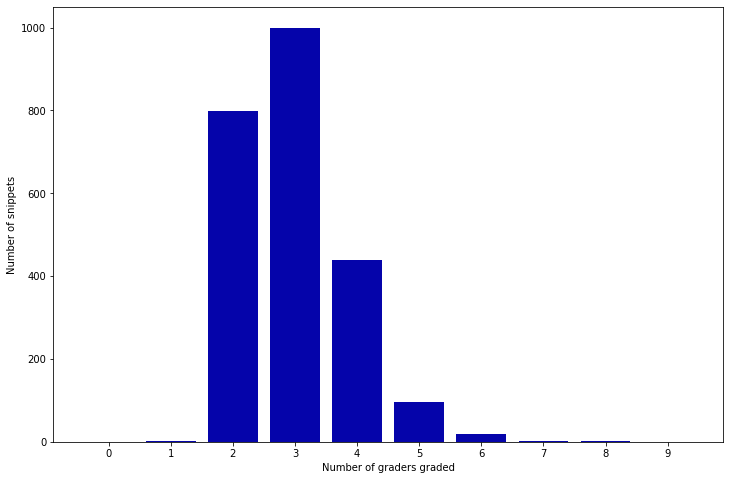

In [38]:
import matplotlib.pyplot as plt
import numpy as np
pos = np.arange(10)
# An "interface" to matplotlib.axes.Axes.hist() method
plt.figure(figsize=(12,8))
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(pos)
plt.bar(pos, cnt, color='#0504aa')
plt.xlabel('Number of graders graded')
plt.ylabel('Number of snippets')

[]

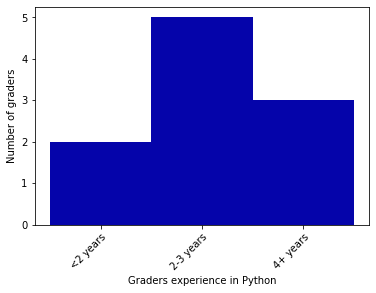

In [112]:
fig, ax= plt.subplots()
my_bins = [0,2,4,6]
ind = np.array(my_bins[:-1])
width = np.array([my_bins[i+1]-my_bins[i] for i in range(len(my_bins)-1)])
ax.set_xticks(ind + width/2)
ax.set_xticklabels(['<2 years', '2-3 years', '4+ years'],rotation=45, rotation_mode="anchor", ha="right")
plt.xlabel('Graders experience in Python')
plt.ylabel('Number of graders')
plt.hist([2,2,2,1,2,4,4,1.5,3,4], bins=my_bins, color='#0504aa')
plt.plot(figsize=(8,6))

In [9]:
import re

def sort_human(l):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    l.sort(key=alphanum)
    return l

In [10]:
all_grades_names = ['grade-baseline', 'grade-tranx-annot', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-snippet']
outp = []
with open('grades.txt', 'w') as o:
    for i, data in enumerate(clean_data): #i is the grader id
        for j, entry in enumerate(data):
            for k, gn in enumerate(all_grades_names):
                if len(entry[gn]) > 0:
                    data_id = j + k*len(data) # task id is j + k * length of dataset, k corresponds to ids of various dataset
                    outp.append(str(data_id)+ ' '+ str(i) + ' ' + str(myroundlist(entry[gn]))+'\n')
    outp = sort_human(outp)
    o.writelines(outp)

In [11]:
with open('grades.txt') as o:
    tmp = o.readlines()
    print(len(tmp))

6984


## Hearthstone dataset

In [35]:
data_hearth = []

In [36]:
for i in range(1, 67):
    tmp = dict()
    snippet = open('./test_bleu/g'+str(i)+'.txt', 'r')
    gcnn = open('./test_bleu/f'+str(i)+'.txt', 'r')
    tmp['snippet'] = snippet.read().strip()
    tmp['gcnn'] = gcnn.read().strip()
    data_hearth.append(tmp)
    snippet.close()
    gcnn.close()

In [38]:
len('reference code for')

18

In [39]:
with open('nl2code-hs.txt', 'r') as f:
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        if line[:24] == 'canonicalized prediction':
            line = f.readline()
            tmpline = ''
            while line[0:18] != 'reference code for':
                tmpline += line
                line = f.readline()
            data_hearth[i]['nl2code'] = tmpline
            i += 1

In [1380]:
data_hearth[0]

{'snippet': 'class Archmage(MinionCard ) : \n    def __init__ (self) :\n        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)\n\n    def create_minion (self, player) :\n        return Minion(4, 7, spell_damage = 1)',
 'gcnn': 'class Archmage(MinionCard ) : \n    def __init__ (self) :\n        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)\n\n    def create_minion (self, player) :\n        return Minion(4, 7, spell_damage = 1)',
 'nl2code': "class Archmage(MinionCard):\n\n    def __init__(self):\n        super().__init__('Archmage', 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON\n            )\n\n    def create_minion(self, player):\n        return Minion(4, 7, spell_damage=1)\n"}

In [1381]:
import json
with open('hs.json', 'w') as outfile:
    json.dump(data_hearth, outfile)

## Django dataset

In [41]:
import pickle
trdata = pickle.load(open('metrics-evaluation/output.decode', 'rb'))
data_django = []

In [80]:
data_django = []
with open('nl2code-django.txt', 'r') as f:
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        if line[:6] == 'intent':
            tmp = dict()
            tmpline = ''           
            line = f.readline()
            while line[0:23] != 'canonicalized reference':
                tmpline += line
                line = f.readline()
            tmp['intent'] = tmpline.strip()
            tmpline = ''
            line = f.readline()
            while line[0:24] != 'canonicalized prediction':
                tmpline += line
                line = f.readline()
            tmp['snippet'] = tmpline.strip()
            tmpline = ''
            line = f.readline()
            while line[0:18] != 'reference code for': 
                tmpline += line
                line = f.readline()
            tmp['nl2code'] = tmpline.strip()
            data_django.append(tmp)
            i += 1
print(i)

1800


In [91]:
data_django2[0]

{'intent': 'params is an empty list,',
 'reranker': 'params = []',
 'tranx': 'params = []'}

In [87]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

'params is an empty list,'

In [190]:
for i in range(len(data_django)):
    if similar(data_django[i]['intent'], data_django2[i]['intent']) > 0.90:
        data_django[i].update(data_django2[i])
for i in range(838,1453):
    if similar(data_django[i]['intent'], data_django2[i+1]['intent']) > 0.90:
        data_django[i].update(data_django2[i+1])
for i in range(1453,len(data_django)):
    if similar(data_django[i]['intent'], data_django2[i+5]['intent']) > 0.90:
        data_django[i].update(data_django2[i+5])

In [1325]:
i = 0
for item in data_django:
    if len(item) == 5:
        i+=1
print(i)

1774


In [188]:
data_django2[1453]

{'intent': 'call the function re.compile [ re. compile ] with an argument raw string _STR:0_. *? _STR:1_, substitute the result for constant_re.',
 'reranker': "constant_re = re.compile('_STR:0_', '')",
 'tranx': "constant_re = re.compile('_STR:0_', '_STR:1_')"}

In [475]:
data_django[1449]

{'intent': 'call the function re.compile with an argument raw string "(?<!%)%(?!%)", substitute the result for one_percent_re.',
 'snippet': "one_percent_re = re.compile('_STR:0_')",
 'nl2code': "one_percent_re = re.compile('_STR:0_')"}

In [1379]:
for i, item in enumerate(data_django):
    if len(item) < 5:
        print(i)
        print(item)
        print(data_django2[i+5])
        break

In [1384]:
data_django[0]

{'intent': 'params is an empty list,',
 'snippet': 'params = []',
 'nl2code': 'params = []',
 'reranker': 'params = []',
 'tranx': 'params = []'}

In [1382]:
with open('django.json', 'w') as outfile:
    json.dump(data_django, outfile)

## Computer metrics

### Django

In [158]:
with open('django.json') as o:
    data_django = json.load(o)

In [159]:
for i, d in enumerate(data_django):
    for n in ['nl2code', 'reranker', 'tranx']:
        hyp = tknz(d[n]) 
        snp = tknz(d['snippet'])
        d['grade-bleu-'+n] = round(sentence_bleu([snp], hyp),4)

/opt/anaconda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.

In [160]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2)
for nam in ['nl2code', 'reranker', 'tranx']:
    keyn = 'grade-rougel-'+nam
    for d in data_django:
        hypt = d[nam]
        refr = d['snippet']
        if hypt[0] is not '':
            scores = evaluator.get_scores(hypt, refr)
            d[keyn] = round(scores['rouge-l']['f'], 4)
        else:
            d[keyn] = 0.0

In [181]:
for nam in ['nl2code', 'reranker', 'tranx']:
    keyn = 'grade-meteor-'+nam
    for d in data_django:
        hypt = d[nam]
        refr = d['snippet']
        if hypt is not '':
            d[keyn] = round(mym.single_meteor_score(refr, hypt), 4)
        else:
            d[keyn] = 0.0

In [172]:
for d in data_django:
    for nam in ['nl2code', 'reranker', 'tranx']:
        sample = d[nam].replace('`', '"')
        snp = d['snippet'].replace('`', '"')
        d['grade-ruby-'+nam] = ruby(sample, snp)[0]

In [182]:
data_django

[{'intent': 'params is an empty list,',
  'snippet': 'params = []',
  'nl2code': 'params = []',
  'reranker': 'params = []',
  'tranx': 'params = []',
  'grade-bleu-nl2code': 1.0,
  'grade-bleu-reranker': 1.0,
  'grade-bleu-tranx': 1.0,
  'grade-rougel-nl2code': 1.0,
  'grade-rougel-reranker': 1.0,
  'grade-rougel-tranx': 1.0,
  'grade-meteor-nl2code': 0.9922,
  'grade-meteor-reranker': 0.9922,
  'grade-meteor-tranx': 0.9922,
  'grade-ruby-nl2code': 1.0,
  'grade-ruby-reranker': 1.0,
  'grade-ruby-tranx': 1.0},
 {'intent': 'if not,',
  'snippet': 'if True:\n    pass\nelse:\n    pass',
  'nl2code': 'if True:\n    pass\nelse:\n    pass',
  'reranker': 'if True:\n    pass\nelse:\n    pass',
  'tranx': 'if True:\n    pass\nelse:\n    pass',
  'grade-bleu-nl2code': 1.0,
  'grade-bleu-reranker': 1.0,
  'grade-bleu-tranx': 1.0,
  'grade-rougel-nl2code': 1.0,
  'grade-rougel-reranker': 1.0,
  'grade-rougel-tranx': 1.0,
  'grade-meteor-nl2code': 0.9985,
  'grade-meteor-reranker': 0.9985,
  'gra

In [9]:
print(sum([item['grade-bleu-tranx'] for item in data_django])/len(data_django))
print(sum([item['grade-bleu-reranker'] for item in data_django])/len(data_django))
print(sum([item['grade-bleu-nl2code'] for item in data_django])/len(data_django))

0.7218497777777787
0.7367323333333335
0.7176763333333334


In [183]:
from collections import defaultdict
django_grades = defaultdict(dict)
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for field in ['nl2code', 'reranker', 'tranx']:
        django_grades[metric][field] = []
for entry in data_django:
    for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
        for field in ['nl2code', 'reranker', 'tranx']:
            django_grades[metric][field].append(entry['grade-'+metric+'-'+field])
print(django_grades)

defaultdict(<class 'dict'>, {'bleu': {'nl2code': [1.0, 1.0, 0.0, 0.3265, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.2784, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.6998, 1.0, 1.0, 0.5969, 0.3527, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7612, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.4957, 0.6998, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6998, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.9036, 0.7911, 1.0, 1.0, 1.0, 1.0, 0.7577, 0.6998, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.9036, 0.7911, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4624, 1.0, 0.4013, 1.0, 0.3689, 1.0, 0.2795, 0.0, 0.4624, 1.0, 0.4013, 1.0, 0.624, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.6475, 0.2201, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.2201, 1.0, 0.2276, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7825, 0.6606, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5877, 0.2737, 1.0, 1

In [184]:
print(sum([item['grade-ruby-tranx'] for item in data_django])/len(data_django))
print(sum([item['grade-ruby-reranker'] for item in data_django])/len(data_django))
print(sum([item['grade-ruby-nl2code'] for item in data_django])/len(data_django))

0.9172151977377554
0.92255992167879
0.9234862234637274


In [185]:
import scipy.stats as stats
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for i, field1 in enumerate(['nl2code', 'tranx', 'reranker']):
        for j, field2 in enumerate(['nl2code', 'tranx', 'reranker']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(django_grades[metric][field1], django_grades[metric][field2], alternative='less')[1],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric,Model A,Model B,Wilcoxon
bleu,nl2code,tranx,0.014
bleu,nl2code,reranker,0.0
bleu,tranx,reranker,0.0
rougel,nl2code,tranx,0.1
rougel,nl2code,reranker,0.0
rougel,tranx,reranker,0.0
meteor,nl2code,tranx,0.015
meteor,nl2code,reranker,0.0
meteor,tranx,reranker,0.0
ruby,nl2code,tranx,0.423


In [191]:
seedbleu = [0.001*i for i in range(1001)]
#logus = [myround(gradese[i], gradesm[i]) for i in range(len(gradese))]
from sklearn.linear_model import LogisticRegression
import numpy as np
outbleu = bleulog.predict_proba(np.array(seedbleu).reshape(-1,1))
outmet = metlog.predict_proba(np.array(seedbleu).reshape(-1,1))
outrou = roulog.predict_proba(np.array(seedbleu).reshape(-1,1))
outruby = rubylog.predict_proba(np.array(seedbleu).reshape(-1,1))

In [201]:
names = ['nl2code', 'tranx', 'reranker']
metrics = ['bleu', 'rougel', 'meteor', 'ruby']
m2 = {'bleu': outbleu, 'rougel': outrou, 'meteor': outmet, 'ruby': outruby}
probdict = defaultdict(dict)
#problist = [0]*2001
#problist[0] = 1
for metric in metrics:
    for nam in names:
        probdict[metric][nam] = [0 for i in range(4*len(data_django)+3)]
        probdict[metric][nam][0] = 1
        cut = 1
        for j in django_grades[metric][nam]:
            try:
                probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(j,3))], cut)
            except:
                probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(1.0,3))], cut)
            cut += 4

In [202]:
tmp = []
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby']
tmp.append(['Metric', 'Model 1', 'Model 2', 'P(2 > 1)'])
for metric in all_metrics:
    for j, nam1 in enumerate(['nl2code', 'tranx', 'reranker']):
        for k, nam2 in enumerate(['nl2code', 'tranx', 'reranker']):
            if j < k:
                comp_prob = 0
                for i in range(len(probdict[metric][nam1])-1):
                    comp_prob += probdict[metric][nam1][i]*sum(probdict[metric][nam2][i+1:])
                tmp.append([metric, nam1, nam2, str(round(1.0-comp_prob, 3))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))      

Metric,Model 1,Model 2,P(2 > 1)
bleu,nl2code,tranx,0.479
bleu,nl2code,reranker,0.187
bleu,tranx,reranker,0.203
rougel,nl2code,tranx,0.713
rougel,nl2code,reranker,0.545
rougel,tranx,reranker,0.329
meteor,nl2code,tranx,0.607
meteor,nl2code,reranker,0.35
meteor,tranx,reranker,0.258
ruby,nl2code,tranx,0.675


In [242]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
all_dj_grades = {'bleu': [], 'rougel': [], 'meteor': [], 'ruby': []}
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby']
for metric in all_metrics:
    for field in ['nl2code', 'tranx', 'reranker']:
        for i in range(1800):
            tt = 'grade-'+metric+'-'+field
            all_dj_grades[metric].append(data_django[i][tt])

for i, metric1 in enumerate(all_metrics):
    for j, metric2 in enumerate(all_metrics):
        if i < j:
            tmp.append([metric1, metric2, str(round(stats.spearmanr(all_dj_grades[metric1], all_dj_grades[metric2])[0],3)), str(round(stats.kendalltau(all_dj_grades[metric1], all_dj_grades[metric2])[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric 1,Metric 2,Spearman,Kendall tau
bleu,rougel,0.66,0.64
bleu,meteor,0.814,0.65
bleu,ruby,0.656,0.621
rougel,meteor,0.74,0.639
rougel,ruby,0.993,0.944
meteor,ruby,0.737,0.623


### Hearthstone

In [185]:
for i, d in enumerate(data_hearth):
    for n in ['nl2code', 'gcnn']:
        hyp = tknz(d[n])
        snp = tknz(d['snippet'])
        d['grade-bleu-'+n] = round(sentence_bleu([snp], hyp),4)

In [186]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2)
for nam in ['nl2code', 'gcnn']:
    keyn = 'grade-rougel-'+nam
    for d in data_hearth:
        hypt = d[nam]
        refr = d['snippet']
        if hypt[0] != '':
            scores = evaluator.get_scores(hypt, refr)
            d[keyn] = round(scores['rouge-l']['f'], 4)
        else:
            d[keyn] = 0.0

In [187]:
for nam in ['nl2code', 'gcnn']:
    keyn = 'grade-meteor-'+nam
    for d in data_hearth:
        hypt = d[nam]
        refr = d['snippet']
        if hypt != '':
            d[keyn] = round(mym.single_meteor_score(refr, hypt), 4)
        else:
            d[keyn] = 0.0

In [188]:
for d in data_hearth:
    for nam in ['nl2code', 'gcnn']:
        sample = d[nam].replace('`', '"')
        snp = d['snippet'].replace('`', '"')
        d['grade-ruby-'+nam] = ruby(sample, snp)[0]

In [46]:
len(data_hearth)

66

In [189]:
from collections import defaultdict
hearth_grades = defaultdict(dict)
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for field in ['nl2code', 'gcnn']:
        hearth_grades[metric][field] = []
for entry in data_hearth:
    for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
        for field in ['nl2code', 'gcnn']:
            hearth_grades[metric][field].append(entry['grade-'+metric+'-'+field])

In [190]:
import scipy.stats as stats
tmp = [['Metric', 'Model A', 'Model B', 'Wilcoxon']]
for metric in ['bleu', 'rougel', 'meteor', 'ruby']:
    for i, field1 in enumerate(['gcnn', 'nl2code']):
        for j, field2 in enumerate(['gcnn', 'nl2code']):
            if i < j:
                tmp.append([metric, field1, field2, str(round(stats.wilcoxon(hearth_grades[metric][field1], hearth_grades[metric][field2], alternative='less')[1],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric,Model A,Model B,Wilcoxon
bleu,gcnn,nl2code,0.076
rougel,gcnn,nl2code,0.108
meteor,gcnn,nl2code,0.012
ruby,gcnn,nl2code,0.047


In [147]:
print(sum(hearth_grades['bleu']['nl2code'])/66)
print(sum(hearth_grades['bleu']['gcnn'])/66)

0.7657560606060607
0.7397999999999999


In [191]:
grades = eval(open('hs-integrated.txt').read())

all_grades_names = ['gcnn', 'nl2code', 'snippet']
for nam in all_grades_names:
    hearth_grades['grade-average'][nam] = [-1 for _ in range(66)]
for key, value in grades.items():
    num = int(key)
    grade_name = all_grades_names[int(num / 66)]
    tt =int(max(value, key=value.get))
    hearth_grades['grade-average'][grade_name][num % 66] = tt
    data_hearth[num % 66]['grade-average-'+grade_name] = tt


In [192]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
all_grades = {'bleu': [], 'rougel': [], 'meteor': [], 'ruby': [], 'average': []}
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby', 'average']
for metric in all_metrics:
    for field in ['gcnn', 'nl2code']:
        for i in range(66):
            tt = 'grade-'+metric+'-'+field
            all_grades[metric].append(data_hearth[i][tt])

for i, metric1 in enumerate(all_metrics):
    for j, metric2 in enumerate(all_metrics):
        if i < j:
            tmp.append([metric1, metric2, str(round(stats.spearmanr(all_grades[metric1], all_grades[metric2])[0],3)), str(round(stats.kendalltau(all_grades[metric1], all_grades[metric2])[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric 1,Metric 2,Spearman,Kendall tau
bleu,rougel,0.991,0.937
bleu,meteor,0.97,0.864
bleu,ruby,0.973,0.884
bleu,average,0.887,0.754
rougel,meteor,0.973,0.87
rougel,ruby,0.969,0.879
rougel,average,0.895,0.764
meteor,ruby,0.955,0.832
meteor,average,0.9,0.772
ruby,average,0.9,0.773


In [219]:
stats.wilcoxon(hearth_grades['human-average']['gcnn'], hearth_grades['human-average']['nl2code'], alternative='less')

WilcoxonResult(statistic=141.0, pvalue=0.02384694223004412)

In [193]:
data_hearth

[{'snippet': 'class Archmage(MinionCard ) : \n    def __init__ (self) :\n        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)\n\n    def create_minion (self, player) :\n        return Minion(4, 7, spell_damage = 1)',
  'gcnn': 'class Archmage(MinionCard ) : \n    def __init__ (self) :\n        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)\n\n    def create_minion (self, player) :\n        return Minion(4, 7, spell_damage = 1)',
  'nl2code': "class Archmage(MinionCard):\n\n    def __init__(self):\n        super().__init__('Archmage', 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON\n            )\n\n    def create_minion(self, player):\n        return Minion(4, 7, spell_damage=1)\n",
  'grade-bleu-nl2code': 1.0,
  'grade-bleu-gcnn': 1.0,
  'grade-rougel-nl2code': 1.0,
  'grade-rougel-gcnn': 1.0,
  'grade-meteor-nl2code': 1.0,
  'grade-meteor-gcnn': 1.0,
  'grade-ruby-nl2code': 1.0,
  'grade-ruby-gcnn': 1.0,
  'grade-average-snippet': 4,
 

In [194]:
hearth_diff = defaultdict()
for metric in metrics:
    hearth_diff[metric] = [dict() for _ in range(len(data_hearth))]
hearth_diff['average'] = [dict() for _ in range(len(data_hearth))]
for metric in metrics:
    for i, item in enumerate(data_hearth):
        for grade in ['nl2code', 'gcnn']:
            hearth_diff[metric][i][grade] = item['grade-average-'+grade]/4.0 - item['grade-'+metric+'-'+grade]
        hearth_diff[metric][i]['num'] = i   
for i, item in enumerate(data_hearth):
    for grade in ['nl2code', 'gcnn']:
        hearth_diff['average'][i][grade] = item['grade-average-'+grade]/4.0
    hearth_diff['average'][i]['num'] = i   

In [208]:
def find_inflection_hs(grades, left, right, check_metric, list_fields):
    if (right - left) < 2:
        return right
    t23 = [data_hearth[it['num']] for it in grades[0:upround(left, right)]]
    split_grades23 = defaultdict(dict)
    for metric in [check_metric, 'average']:
        for field in list_fields:
            split_grades23[metric][field] = []
    for entry in t23:
        for metric in [check_metric, 'average']:
            for field in list_fields:
                split_grades23[metric][field].append(entry['grade-'+metric+'-'+field])
    if (round(stats.wilcoxon(split_grades23[metric][list_fields[1]], split_grades23[metric][list_fields[0]], alternative='greater')[1],3) < 0.95):
        return find_inflection_hs(grades, left, upround(left, right), check_metric, list_fields)
    else:
        return find_inflection_hs(grades, upround(left, right), right, check_metric, list_fields)

In [210]:
tmp = [['Metric', 'Model A', 'Model B', 'Inflection point 1', 'Inflection point 2']]
for metric in all_metrics:
    gd23 = sorted(hearth_diff[metric], key = lambda k: k['nl2code'] - k['gcnn'])
    tmp.append([metric, 'nl2code', 'gcnn', find_inflection_hs(gd23, 4, len(data_hearth), metric, ['gcnn', 'nl2code']), find_inflection_hs(gd23, 8, len(data_hearth), metric,  ['gcnn', 'nl2code'])])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))        

Metric,Model A,Model B,Inflection point 1,Inflection point 2
bleu,nl2code,gcnn,45,45
rougel,nl2code,gcnn,50,50
meteor,nl2code,gcnn,38,38
ruby,nl2code,gcnn,47,47
average,nl2code,gcnn,54,54


# Here

In [240]:
tmp = [['Metric 1', 'Metric 2', 'Spearman', 'Kendall tau']]
graders = ['Misha', 'Egor', 'Yaroslav', 'Alyona']
all_hum_grades = {'Misha': [], 'Egor': [], 'Yaroslav': [], 'Alyona': []}
for i, ds in enumerate([hs_misha, hs_egor, hs_areyde, hs_alyona]):
    for field in ['gcnn', 'nl2code']:
        for j in range(66):
            tt = 'grade-'+field
            all_hum_grades[graders[i]].append(ds[j][tt])

for i in range(4):
    for j in range(4):
        if i < j:
            tmp.append([graders[i], graders[j], str(round(stats.spearmanr(all_hum_grades[graders[i]], all_hum_grades[graders[j]])[0],3)), str(round(stats.kendalltau(all_grades[metric1], all_grades[metric2])[0],3))])
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))

Metric 1,Metric 2,Spearman,Kendall tau
Misha,Egor,0.834,1.0
Misha,Yaroslav,0.797,1.0
Misha,Alyona,0.708,1.0
Egor,Yaroslav,0.82,1.0
Egor,Alyona,0.765,1.0
Yaroslav,Alyona,0.713,1.0


2.6363636363636362
2.9242424242424243
2.5833333333333335
2.0454545454545454


In [247]:
names = ['gcnn', 'nl2code']
metrics = ['bleu', 'rougel', 'meteor', 'ruby']
m2 = {'bleu': outbleu, 'rougel': outrou, 'meteor': outmet, 'ruby': outruby}
probdict = defaultdict(dict)
#problist = [0]*2001
#problist[0] = 1
for metric in metrics:
    for nam in names:
        probdict[metric][nam] = [0 for i in range(4*len(data_hearth)+1)]
        probdict[metric][nam][0] = 1
        cut = 1
        for j in hearth_grades[metric][nam]:
            try:
                probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(j,3))], cut)
            except:
                probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(1.0,3))], cut)
            cut += 4

In [248]:
tmp = []
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby']
tmp.append(['Metric', 'Model 1', 'Model 2', 'P(2 > 1)'])
for metric in all_metrics:
    for j, nam1 in enumerate(['gcnn', 'nl2code']):
        for k, nam2 in enumerate(['gcnn', 'nl2code']):
            if j < k:
                comp_prob = 0
                for i in range(len(probdict[metric][nam1])-1):
                    comp_prob += probdict[metric][nam1][i]*sum(probdict[metric][nam2][i+1:])
                tmp.append([metric, nam1, nam2, str(round(1.0-comp_prob, 3))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html')))   

Metric,Model 1,Model 2,P(2 > 1)
bleu,gcnn,nl2code,0.378
rougel,gcnn,nl2code,0.422
meteor,gcnn,nl2code,0.292
ruby,gcnn,nl2code,0.388


### HS-based logistic regression

In [153]:
hslog_grades = dict()
for metric in ['bleu', 'rougel', 'meteor', 'ruby', 'grade-average']:
    hslog_grades[metric] = hearth_grades[metric]['gcnn'] + hearth_grades[metric]['nl2code']

132

In [156]:
seedbleu = [0.001*i for i in range(1001)]
#logus = [myround(gradese[i], gradesm[i]) for i in range(len(gradese))]
from sklearn.linear_model import LogisticRegression
import numpy as np
hsbleulog = LogisticRegression()
hsbleulog.fit(np.array(hslog_grades['bleu']).reshape(-1, 1), np.array(hslog_grades['grade-average']).reshape(-1, 1))
hsoutbleu = hsbleulog.predict_proba(np.array(seedbleu).reshape(-1,1))
hsmetlog = LogisticRegression()
hsmetlog.fit(np.array(hslog_grades['meteor']).reshape(-1, 1), np.array(hslog_grades['grade-average']).reshape(-1, 1))
hsoutmet = hsmetlog.predict_proba(np.array(seedbleu).reshape(-1,1))
hsroulog = LogisticRegression()
hsroulog.fit(np.array(hslog_grades['rougel']).reshape(-1, 1), np.array(hslog_grades['grade-average']).reshape(-1, 1))
hsoutrou = hsroulog.predict_proba(np.array(seedbleu).reshape(-1,1))
hsrubylog = LogisticRegression()
hsrubylog.fit(np.array(hslog_grades['ruby']).reshape(-1, 1), np.array(hslog_grades['grade-average']).reshape(-1, 1))
hsoutruby = hsrubylog.predict_proba(np.array(seedbleu).reshape(-1,1))

/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConvers

In [160]:
names = ['gcnn', 'nl2code']
metrics = ['bleu', 'rougel', 'meteor', 'ruby']
m2 = {'bleu': hsoutbleu, 'rougel': hsoutrou, 'meteor': hsoutmet, 'ruby': hsoutruby}
probdict = defaultdict(dict)
#problist = [0]*2001
#problist[0] = 1
for metric in metrics:
    for nam in names:
        probdict[metric][nam] = [0 for i in range(4*len(data_hearth)+1)]
        probdict[metric][nam][0] = 1
        cut = 1
        for j in hearth_grades[metric][nam]:
            probdict[metric][nam] = contract_prob(probdict[metric][nam], m2[metric].tolist()[int(1000*round(j,3))], cut)
            cut += 4

In [161]:
tmp = []
all_metrics = ['bleu', 'rougel', 'meteor', 'ruby']
tmp.append(['Metric', 'Model 1', 'Model 2', 'P(2 > 1)'])
for metric in all_metrics:
    for j, nam1 in enumerate(['gcnn', 'nl2code']):
        for k, nam2 in enumerate(['gcnn', 'nl2code']):
            if j < k:
                comp_prob = 0
                for i in range(len(probdict[metric][nam1])-1):
                    comp_prob += probdict[metric][nam1][i]*sum(probdict[metric][nam2][i+1:])
                tmp.append([metric, nam1, nam2, str(round(1.0-comp_prob, 3))])
display(HTML(tabulate.tabulate(tmp, tablefmt='html'))) 

Metric,Model 1,Model 2,P(2 > 1)
bleu,gcnn,nl2code,0.422
rougel,gcnn,nl2code,0.477
meteor,gcnn,nl2code,0.349
ruby,gcnn,nl2code,0.415


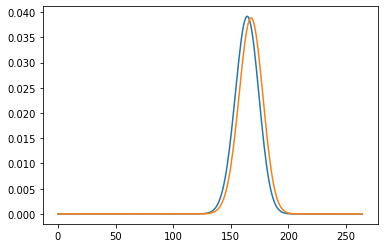

In [167]:
plt.plot(probdict['bleu']['gcnn'])
plt.plot(probdict['bleu']['nl2code'])
plt.show()

In [387]:
import codebleu
import importlib
import ast
from tree_sitter import Language, Parser
parser = Parser()
PY_LANGUAGE = Language('./my-languages.so', 'python')
parser.set_language(PY_LANGUAGE)
importlib.reload(codebleu)
importlib.reload(gu)
codebleu.ast_match(data_hearth[3]['snippet'], data_hearth[3]['nl2code'], parser)

0.8840579710144928

In [223]:
import bleu_score
importlib.reload(bleu_score)
r = codebleu.tokenize_builtin(data_hearth[0]['snippet'])
c = codebleu.tokenize_builtin(data_hearth[0]['snippet'])
bleu_score.compute_bleu([[r]], [c])

(1.0, [1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 61, 61)

In [218]:
print(data_hearth[0]['snippet'])

class Archmage(MinionCard ) : 
    def __init__ (self) :
        super().__init__("Archmage", 6, CHARACTER_CLASS.ALL, CARD_RARITY.COMMON)

    def create_minion (self, player) :
        return Minion(4, 7, spell_damage = 1)


In [394]:
ref_parsed = gu.prettyprint_graph(gg.AstGraphGenerator(data_django[96]['snippet'], lattice).build())

{'edges': {'CHILD': {'0_Module': ['1_If'],
                     '13_Name': ['14_bytes'],
                     '18_BoolOp': ['19_Call', '30_and', '31_Attribute'],
                     '19_Call': ['20_Name',
                                 '22_(',
                                 '23_Name',
                                 '25_,',
                                 '26_Name',
                                 '29_)'],
                     '1_If': ['2_if',
                              '3_BoolOp',
                              '37_<INDENT>',
                              '38_Pass',
                              '40_<DEDENT>',
                              '41_else',
                              '42_<INDENT>',
                              '43_<DEDENT>'],
                     '20_Name': ['21_isinstance'],
                     '23_Name': ['24_s'],
                     '26_Name': ['27_Promise'],
                     '31_Attribute': ['32_Name', '34_.', '35__delegate_bytes'],
                  

In [396]:
importlib.reload(codebleu)
for i, item in enumerate(data_django):
    print(i, codebleu.codebleu(item['snippet'], item['nl2code']))
for i, item in enumerate(clean_dataset):
    for item1, item2 in zip(item['snippet'], item['baseline']):
        print(i, codebleu.codebleu(item1, item2))
for i, item in enumerate(data_hearth):
    print(i, codebleu.codebleu(item['snippet'], item['nl2code']))

0 1.0
1 1.0
2 0.2783824684919105
3 0.5908274150538219
4 1.0
5 0.37545787545787546
6 0.5062141609852951
7 1.0
8 1.0
9 0.8333333333333333
10 0.37464318292737453
11 1.0
12 0.2559626902751518
13 1.0
14 1.0
15 1.0
16 0.35353535353535354
17 0.8114533688690854
18 1.0
19 1.0
20 0.9263395010793742
21 0.5647315910148583
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 0.9656274990854024
32 1.0
33 0.2942554843649264
34 0.1607886239247292
35 1.0
36 1.0
37 1.0
38 0.4800228631815278
39 0.8114533688690854
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 0.8333333333333333
46 1.0
47 0.8333333333333333
48 0.9594736765858224
49 0.8333333333333333
50 1.0
51 1.0
52 1.0
53 1.0
54 1.0
55 1.0
56 1.0
57 0.8333333333333333
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 0.8333333333333333
66 1.0
67 0.9644028240745622
68 0.952357238375393
69 1.0
70 1.0
71 1.0
72 1.0
73 0.8228639374575037
74 0.9594736765858224
75 1.0
76 1.0
77 1.0
78 1.0
79 0.8333333333333333
80 1.0
81 0.9644028240745622
82 0.952357238

622 0.2518325061922109
623 0.3422869348518985
624 1.0
625 1.0
626 1.0
627 1.0
628 1.0
629 1.0
630 0.09774088917807373
631 1.0
632 0.14508093315891057
633 0.9544977890801811
634 0.31313131313131304
635 0.9544977890801811
636 0.8333333333333333
637 1.0
638 0.8333333333333333
639 0.2139024069582506
640 0.5182222069549176
641 0.09774088917807373
642 1.0
643 0.8333333333333333
644 1.0
645 1.0
646 1.0
647 1.0
648 0.5977627478100129
649 0.9656274990854024
650 1.0
651 0.5017656451675107
652 1.0
653 1.0
654 0.26849323234950456
655 1.0
656 0.8333333333333333
657 0.17941835529407402
658 1.0
659 1.0
660 1.0
661 1.0
662 0.8526426517628826
663 1.0
664 1.0
665 1.0
666 0.8333333333333333
667 1.0
668 1.0
669 0.7980441393843909
670 1.0
671 0.5282719503848181
672 1.0
673 1.0
674 1.0
675 1.0
676 0.8333333333333333
677 1.0
678 0.9588550875551268
679 1.0
680 1.0
681 0.33988571916321414
682 0.8333333333333333
683 1.0
684 1.0
685 1.0
686 0.5657853301225424
687 1.0
688 0.3083217421925125
689 1.0
690 1.0
691 0.

1228 1.0
1229 0.5762906876669683
1230 0.06959968490153359
1231 0.4013040048105647
1232 1.0
1233 1.0
1234 1.0
1235 0.574074074074074
1236 1.0
1237 0.13314650105384773
1238 1.0
1239 1.0
1240 1.0
1241 1.0
1242 1.0
1243 0.8055555555555556
1244 1.0
1245 1.0
1246 0.7563894774958401
1247 1.0
1248 1.0
1249 1.0
1250 1.0
1251 1.0
1252 1.0
1253 1.0
1254 0.3714932059195703
1255 0.7945817094013227
1256 1.0
1257 1.0
1258 0.8333333333333333
1259 1.0
1260 0.452724358974359
1261 0.9143823426047181
1262 1.0
1263 1.0
1264 1.0
1265 1.0
1266 1.0
1267 1.0
1268 1.0
1269 1.0
1270 1.0
1271 1.0
1272 0.7562330804883902
1273 1.0
1274 1.0
1275 1.0
1276 1.0
1277 1.0
1278 0.7560033945571386
1279 1.0
1280 1.0
1281 1.0
1282 1.0
1283 0.8333333333333333
1284 1.0
1285 1.0
1286 1.0
1287 1.0
1288 1.0
1289 1.0
1290 1.0
1291 1.0
1292 1.0
1293 0.8333333333333333
1294 1.0
1295 0.22470588235294117
1296 0.8166666666666667
1297 1.0
1298 1.0
1299 0.33068477276552277
1300 0.21393989846201564
1301 1.0
1302 1.0
1303 1.0
1304 1.0
1305

7 0.6394107622524057
8 0.13306033649833973
9 0.45079365079365075
10 0.27155666579138316
11 0.02857142857142857
12 0.5528923534397665
13 0.13484848484848486
14 0.25820981257393205
15 0.4074074074074074
16 0.6593406593406593
17 0.33333333333333337
18 0.3172250074433521
19 0.42701525054466233
20 0.36013630068064284
21 0.24941898108649738
22 0.30616024626968824
23 0.3041874562750098
24 0.19181286549707602
25 0.8921679582442842
26 0.01581027836200241
27 0.22778774594064802
28 0.4262820512820512
29 0.07935728037908507
30 0.4167132989302956
31 0.1598978288633461
32 0.1457319739513839
33 0.43693579537794525
34 0.29999999999999993
35 0.3242515827950696
36 0.25847462158874
37 0.19459820505053832
38 0.50997150997151
39 0.19188076222764405
40 0.5472887858953563
41 0.2579500029905199
42 0.4985404184083986
43 0.20096210800009723
44 0.3584319165336781
45 0.2765567765567766
46 0.2668571428571429
47 0.23854100310018844
48 0.41087022990095756
49 0.24305555555555555
50 0.4441995926779154
51 0.20841800032

351 0.15
352 0.11666666666666665
353 0.09000000000000001
354 0.07
355 0.07
356 0.3722839737991061
357 0.25184130695085855
358 0.608058608058608
359 0.17688316768042847
360 0.21055900621118012
361 0.2206145532318874
362 0.42424242424242425
363 0.2765775089867143
363 0.1682059900829496
363 0.32272727272727275
364 0.3361379363448303
365 0.3271967588642752
366 0.25557894736842107
367 0.17899159663865546
368 0.3528598496152936
369 0.5567765567765568
370 0.4321705434551744
371 0.3490771399805238
371 0.4762478561219407
372 0.20968580284722452
373 0.9133034859997452
374 0.4029304029304029
375 0.44907407407407396
376 0.45079365079365075
377 0.37134502923976603
378 0.1
379 0.1688311688311688
380 0.38518518518518513
381 0.2715462783461072
382 0.11540140332748436
383 0.2510869565217391
384 0.5743045386661039
385 0.11666666666666665
386 0.4333333333333333
386 0.4333333333333333
386 0.4333333333333333
386 0.4333333333333333
387 0.07211538461538461
388 0.24281691847803702
389 0.5814814814814815
390 0

In [393]:
data_django[96]

{'intent': 'if s is an instance of bytes or Promise and s._delegate_bytes [ s. _delegate_bytes ] is true,',
 'snippet': 'if isinstance(s, bytes) or isinstance(s, Promise) and s._delegate_bytes:\n    pass',
 'nl2code': 'if isinstance(s, (bytes, Promise)) and not s._delegate_bytes:\n    pass',
 'reranker': 'if isinstance(s, (bytes, Promise)) or s._delegate_bytes and s._delegate_bytes:\n    pass',
 'tranx': 'if isinstance(s, bytes) or s._delegate_bytes:\n    pass'}

In [389]:
for i, item in enumerate(clean_dataset):
    for item1, item2 in zip(item['snippet'], item['baseline']):
        print(i, codebleu.codebleu(item1, item2))

0 0.16693619191856385
1 0.45227038943990827
2 0.6967532467532468
3 0.1644763724236195
4 0.21317342422220462
5 0.2845871980112487
5 0.30399551256281493
6 0.4629629629629629
7 0.6394107622524057
8 0.13306033649833973
9 0.45079365079365075
10 0.27155666579138316
11 0.02857142857142857
12 0.5528923534397665
13 0.13484848484848486
14 0.25820981257393205
15 0.4074074074074074
16 0.6593406593406593
17 0.33333333333333337
18 0.3172250074433521
19 0.42701525054466233
20 0.36013630068064284
21 0.24941898108649738
22 0.30616024626968824
23 0.3041874562750098
24 0.19181286549707602
25 0.8921679582442842
26 0.01581027836200241
27 0.22778774594064802
28 0.4262820512820512
29 0.07935728037908507
30 0.4167132989302956
31 0.1598978288633461
32 0.1457319739513839
33 0.43693579537794525
34 0.29999999999999993
35 0.3242515827950696
36 0.25847462158874
37 0.19459820505053832
38 0.50997150997151
39 0.19188076222764405
40 0.5472887858953563
41 0.2579500029905199
42 0.4985404184083986
43 0.20096210800009723
4

341 0.8331972573807968
342 0.32232165738729274
343 0.13818181818181818
344 0.13501251373245293
345 0.4640522875816993
346 0.14359180054908355
347 0.32233165133891006
348 0.25
349 0.174567492125695
350 0.5946260365415497
351 0.15
352 0.11666666666666665
353 0.09000000000000001
354 0.07
355 0.07
356 0.3722839737991061
357 0.25184130695085855
358 0.608058608058608
359 0.17688316768042847
360 0.21055900621118012
361 0.2206145532318874
362 0.42424242424242425
363 0.2765775089867143
363 0.1682059900829496
363 0.32272727272727275
364 0.3361379363448303
365 0.3271967588642752
366 0.25557894736842107
367 0.17899159663865546
368 0.3528598496152936
369 0.5567765567765568
370 0.4321705434551744
371 0.3490771399805238
371 0.4762478561219407
372 0.20968580284722452
373 0.9133034859997452
374 0.4029304029304029
375 0.44907407407407396
376 0.45079365079365075
377 0.37134502923976603
378 0.1
379 0.1688311688311688
380 0.38518518518518513
381 0.2715462783461072
382 0.11540140332748436
383 0.251086956521

In [17]:
test_snippet = """pd.concat(pd.concat(list(s1.items()), text = s1.size())/list(s1.items()), key = lambda x:t [np.isnan(s2)/1])"""
df_graph = gg.AstGraphGenerator(test_snippet, lattice)
tmp = df_graph.build()
gu.prettyprint_graph(tmp)

{'edges': {'CHILD': {'0_Module': ['1_Expr'],
                     '11_BinOp': ['49_/', '50_Call', '12_Call'],
                     '12_Call': ['35_,',
                                 '36_keyword',
                                 '13_Attribute',
                                 '48_)',
                                 '18_(',
                                 '19_Call'],
                     '13_Attribute': ['16_.', '17_concat', '14_Name'],
                     '14_Name': ['15_pd'],
                     '19_Call': ['24_Call', '34_)', '20_Name', '23_('],
                     '1_Expr': ['2_Call'],
                     '20_Name': ['21_list'],
                     '24_Call': ['32_(', '25_Attribute', '33_)'],
                     '25_Attribute': ['26_Name', '29_.', '30_items'],
                     '26_Name': ['27_s1'],
                     '2_Call': ['64_keyword',
                                '3_Attribute',
                                '99_)',
                                '10_(',


In [18]:
tmp['edges']['NEXT_USE']

{'3_Attribute': ['13_Attribute'],
 '5_pd': ['15_pd'],
 '27_s1': ['42_s1'],
 '21_list': ['52_list'],
 '25_Attribute': ['55_Attribute'],
 '42_s1': ['57_s1']}

In [31]:
import networkx as nx
def _split_identifier(identifier): #The format in which the variables are stored in typilus is slightly unusual: they store variable as a str of format locationInCode_VariableName; it is convenient for me to break this string into a tuple
	lst = identifier.split('_', 1)
	lst[0] = int(lst[0])
	return lst

def _fix_identifier(identifier):
	lst = identifier.split('_', 1)
	lst[0] = int(lst[0]) - 1
	return str(lst[0])+'_'+lst[1]	

def _parse_occurences(occur_dict):
	definitions_list = []
	for key, value in occur_dict.items():
		curr_identifier = _split_identifier(key)
		for item in value:
			curr_identifier = _split_identifier(item)
			curr_identifier[0] -= 1 #to match the standard notation of the variables
			if (curr_identifier not in definitions_list):
				definitions_list.append(curr_identifier)

	definitions_list.sort(key = lambda x: x[0])
	variables_list = [str(item[0])+'_'+item[1] for item in definitions_list] #the part is basically to sort variables according to their location in code; gotta simplify that when won't be this tired
	variables_dict = dict()
	for i, item in enumerate(variables_list):
		variables_dict[item] = 'var_' + str(i) #renaming the variables to a common standard to be name-independent
	for key, value in occur_dict.items():
		if len(value) > 1:
			variables_dict[key] = [variables_dict[_fix_identifier(item)] for item in value]
		else:
			variables_dict[key] = variables_dict[_fix_identifier(value[0])]
	return variables_dict

def _find_node(G, id): #to find a node in the graph by the corresponding variable id (same to location)
	for node in list(G.nodes):
		if G.nodes[node]['id'] == id:
			return node
	return None

def _find_edge(G, edge_data): #find the edge from the candidate graph in the reference graph
	edge_list = list(G.edges)
	edge_list.sort(key = lambda x: x[0])
	for edge in edge_list:
		if ((G.nodes[edge[0]]['data'] == edge_data[0]) and (G.nodes[edge[1]]['data'] == edge_data[1])):
			return edge
	return None

def _find_matching_variable(variables_dict, thekey): #if there are more than one variables with the same name in the code (e.g. we have several functions with same names of local variables), we wanna parse, to which variable do we refer now
	lookup = _split_identifier(thekey)
	match_var = [0, '']
	for key, value in variables_dict.items(): 
		checked = _split_identifier(key)
		if ((lookup[1] == checked[1]) and (lookup[0] >= checked[0]) and (match_var[0] < checked[0])):
			match_var = checked
	return [lookup[0], str(match_var[0]) + '_' + match_var[1]]

def _create_graph(next_use_dict, variables_dict, occur_dict): 
	G = nx.DiGraph()
	nodes_list = []
	for key, value in occur_dict.items():
		toadd = _find_matching_variable(variables_dict, key)
		if (toadd[1] != '0_'): #to disregard the attributes -- afaiu, we don't need them
			nodes_list.append(toadd)
	nodes_list.sort(key = lambda x: x[0])
	for i, item in enumerate(nodes_list):
		G.add_node(i, id=item[0], data=variables_dict[item[1]])
	for key, value in next_use_dict.items():
		from_node = _find_node(G, _split_identifier(key)[0])
		for item in value:
			to_node = _find_node(G, _split_identifier(item)[0])
			G.add_edge(from_node, to_node)
	return G

def _compare_graphs(ref_G, cand_G): #we look up edges from candidate one by one, if they are in the reference; if they are -- increase # of matches by one and pop the corresponding edge from list of ref edges
	matched = 0
	cand_edges = list(cand_G.edges)
	cand_edges.sort(key = lambda x: x[0])
	for edge in cand_edges:
		edge_data = (cand_G.nodes[edge[0]]['data'], cand_G.nodes[edge[1]]['data'])
		matched_edge = _find_edge(ref_G, edge_data)
		if matched_edge is not None:
			ref_G.remove_edge(*matched_edge)
			matched += 1
	return matched

def _fix_graph(g): #pretty print by Egor Bogomolov
    g['token-sequence'] = [f"{ind}_{g['nodes'][ind]}" for ind in g['token-sequence']]
    g['edges'] = {
        edge_type: {
            f"{v}_{g['nodes'][v]}": [f"{u}_{g['nodes'][u]}" for u in us]
            for v, us in g['edges'][edge_type].items()
        }
        for edge_type in g['edges']
    }
    return g

def dfg_match(reference, candidate, lattice): #dfg part of the metric
	try:
		ref_parsed = _fix_graph(gg.AstGraphGenerator(reference, lattice).build())
	except:
		return -1 #we return -1 if it is impossible to do some step for reference snippet and return 0 if it is possible for reference, but not for candidate
	try:
		cand_parsed = _fix_graph(gg.AstGraphGenerator(candidate, lattice).build())
	except:
		return 0
	if (('NEXT_USE' not in ref_parsed['edges']) or ('OCCURRENCE_OF' not in ref_parsed['edges'])):
		return -1
	if (('NEXT_USE' not in cand_parsed['edges']) or ('OCCURRENCE_OF' not in cand_parsed['edges'])):
		return 0
	ref_variables = _parse_occurences(ref_parsed['edges']['OCCURRENCE_OF'])
	cand_variables = _parse_occurences(cand_parsed['edges']['OCCURRENCE_OF'])
	ref_G = _create_graph(ref_parsed['edges']['NEXT_USE'], ref_variables, ref_parsed['edges']['OCCURRENCE_OF'])
	cand_G = _create_graph(cand_parsed['edges']['NEXT_USE'], cand_variables, cand_parsed['edges']['OCCURRENCE_OF'])
	if len(ref_G.edges) == 0:
		return -1
	if len(cand_G.edges) == 0:
		return 0	
	max_match = len(ref_G.edges)
	return _compare_graphs(ref_G, cand_G) / max_match


In [99]:
test_snippet = """pd.concat(pd.concat(list(s1.items()), text = s1.size())/list(s1.items()), key = lambda x:t [np.isnan(s2)/1])"""

In [34]:
cand_parsed = _fix_graph(gg.AstGraphGenerator(test_snippet, lattice).build())

In [35]:
cand_variables = _parse_occurences(cand_parsed['edges']['OCCURRENCE_OF'])

In [36]:
cand_parsed['edges']['NEXT_USE']

{'3_Attribute': ['13_Attribute'],
 '5_pd': ['15_pd'],
 '27_s1': ['42_s1'],
 '21_list': ['52_list'],
 '25_Attribute': ['55_Attribute'],
 '42_s1': ['57_s1']}

In [37]:
cand_parsed['edges']['OCCURRENCE_OF']

{'5_pd': ['6_pd'],
 '3_Attribute': ['9_pd.concat'],
 '15_pd': ['6_pd'],
 '13_Attribute': ['9_pd.concat'],
 '21_list': ['22_list'],
 '27_s1': ['28_s1'],
 '25_Attribute': ['31_s1.items'],
 '42_s1': ['28_s1'],
 '40_Attribute': ['45_s1.size'],
 '52_list': ['22_list'],
 '57_s1': ['28_s1'],
 '55_Attribute': ['31_s1.items'],
 '71_x': ['72_x'],
 '77_t': ['78_t'],
 '85_np': ['86_np'],
 '83_Attribute': ['89_np.isnan'],
 '92_s2': ['93_s2']}

In [38]:
cand_variables

{'5_pd': 'var_0',
 '8_pd.concat': 'var_1',
 '21_list': 'var_2',
 '27_s1': 'var_3',
 '30_s1.items': 'var_4',
 '44_s1.size': 'var_5',
 '71_x': 'var_6',
 '77_t': 'var_7',
 '85_np': 'var_8',
 '88_np.isnan': 'var_9',
 '92_s2': 'var_10',
 '3_Attribute': 'var_1',
 '15_pd': 'var_0',
 '13_Attribute': 'var_1',
 '25_Attribute': 'var_4',
 '42_s1': 'var_3',
 '40_Attribute': 'var_5',
 '52_list': 'var_2',
 '57_s1': 'var_3',
 '55_Attribute': 'var_4',
 '83_Attribute': 'var_9'}

In [22]:
cand_G = _create_graph(cand_parsed['edges']['NEXT_USE'], cand_variables, cand_parsed['edges']['OCCURRENCE_OF'])

52_list
[[5, '5_pd'], [15, '5_pd'], [21, '21_list'], [27, '27_s1'], [42, '27_s1'], [52, '21_list'], [57, '27_s1'], [71, '71_x'], [77, '77_t'], [85, '85_np'], [92, '92_s2']]


KeyError: 'id'

NameError: name 'nodes_list' is not defined